In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
train_df = pd.read_csv("../train.csv")
test_df = pd.read_csv("../test.csv")

In [3]:
merged_df = pd.concat([train_df, test_df])
df_labels = merged_df["Activity"].replace(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'],  [0, 1, 2, 3, 4, 5])
df_features = merged_df.drop(["Activity", "subject"], axis=1)

In [4]:
PCA_features = PCA(n_components=300).fit_transform(df_features, df_labels)

In [5]:
np_X = PCA_features.reshape(PCA_features.shape[0], PCA_features.shape[1])
np_y = df_labels.values.reshape(df_labels.shape[0])

In [6]:
def heatmap_drawing(confusion_matrices, title):
    fig, axs = plt.subplots(len(confusion_matrices), figsize=(20,30))
    for i,cm in enumerate(confusion_matrices):
        ax = axs[i]
        sns.heatmap(cm, annot=True, ax=ax, fmt='d')
        ax.set_title(f"{title} {i+1}")
    plt.tight_layout()
    plt.savefig(f"{title} heatmap")
    plt.show()

In [7]:
knn = RandomizedSearchCV( KNeighborsClassifier(algorithm='auto'), {
    'n_neighbors' : range(1,10,1),
    'weights': ['uniform', 'distance'],
}, cv=5, return_train_score= False, n_iter=5)
knn.fit(df_features, df_labels)
print(f"Best Score in KNN: {knn.best_score_}\n Params: {knn.best_params_}")

Best Score in KNN: 0.9088262753622505
 Params: {'weights': 'uniform', 'n_neighbors': 8}


In [8]:
svm = RandomizedSearchCV( SVC(gamma='auto'),{
    'C': range(1,100),
    'kernel': ['rbf','linear'],
}, cv= 5, return_train_score= False, n_iter=10)
svm.fit(df_features, df_labels)
print(f"Best Score in SVM: {svm.best_score_}\n Params: {svm.best_params_}")

Best Score in SVM: 0.9603847187578097
 Params: {'kernel': 'rbf', 'C': 91}


In [9]:
rfc = RandomizedSearchCV( RandomForestClassifier(),{
    'n_estimators':range(1,200),
    'criterion': ["gini", "entropy", "log_loss"],
    'max_depth':range(100,600,10)
}, cv=5, return_train_score=False, n_iter=10)
rfc.fit(df_features, df_labels)
print(f"Best Score in Random forest classifier: {rfc.best_score_}\n Params: {rfc.best_params_}")

Best Score in Random forest classifier: 0.937081437402453
 Params: {'n_estimators': 135, 'max_depth': 450, 'criterion': 'entropy'}


In [8]:
kfold = KFold(n_splits=5, shuffle=False)

In [9]:
params = knn.best_params_
knn = KNeighborsClassifier(algorithm='auto', weights = params['weights'], n_neighbors = params['n_neighbors'])

In [10]:
knn_cfs = []
for train_index,test_index in kfold.split(np_X):
    X_train, X_test = np_X[train_index], np_X[test_index]
    y_train, y_test = np_y[train_index], np_y[test_index]
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    original = y_test
    cf = metrics.confusion_matrix(pred, original)
    knn_cfs.append(cf)

In [15]:
params = svm.best_params_
svm = SVC(gamma='auto', C = params['C'], kernel=params['kernel'])

In [16]:
svm_cfs=[]
for train_index,test_index in kfold.split(np_X):
    X_train, X_test = np_X[train_index], np_X[test_index]
    y_train, y_test = np_y[train_index], np_y[test_index]
    svm.fit(X_train, y_train)
    pred = svm.predict(X_test)
    original = y_test
    cf = metrics.confusion_matrix(pred, original)
    svm_cfs.append(cf)

In [17]:
params = rfc.best_params_
rfc = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'], criterion=params['criterion'])

In [18]:
rfc_cfs=[]
for train_index,test_index in kfold.split(np_X):
    X_train, X_test = np_X[train_index], np_X[test_index]
    y_train, y_test = np_y[train_index], np_y[test_index]
    rfc.fit(X_train, y_train)
    pred = rfc.predict(X_test)
    original = y_test
    cf = metrics.confusion_matrix(pred, original)
    rfc_cfs.append(cf)

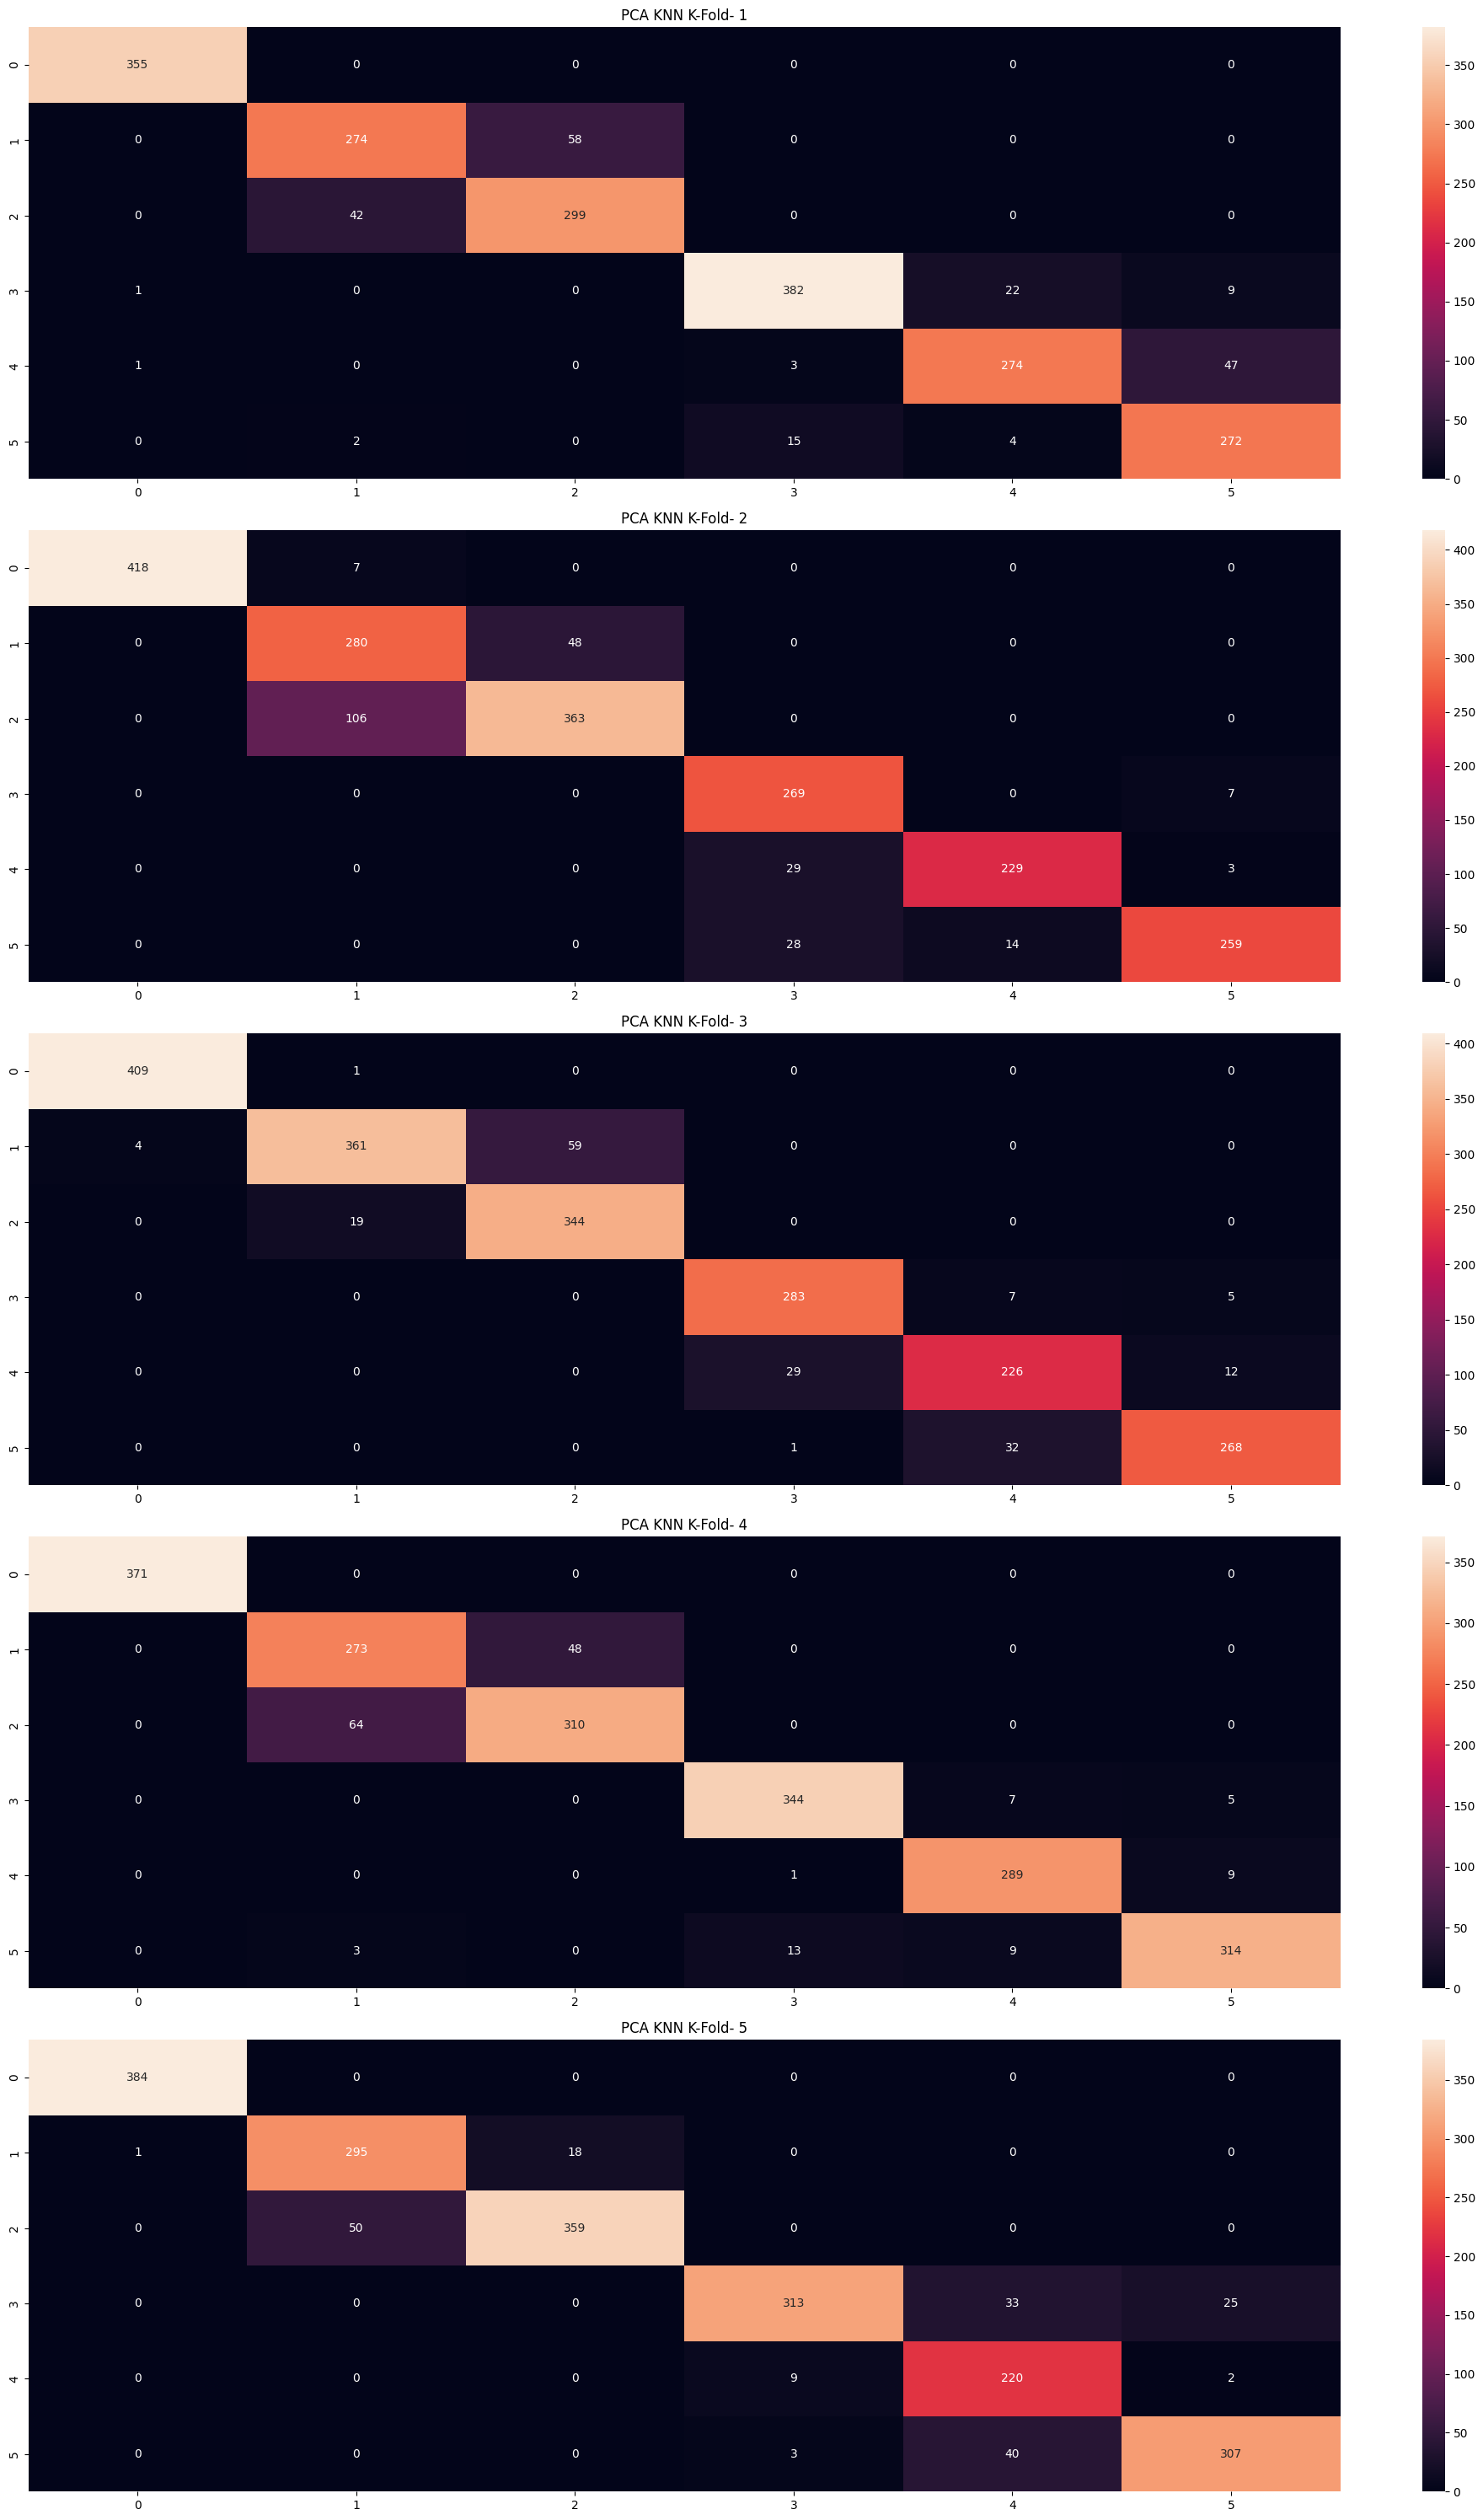

In [19]:
heatmap_drawing(knn_cfs,'PCA KNN K-Fold-')

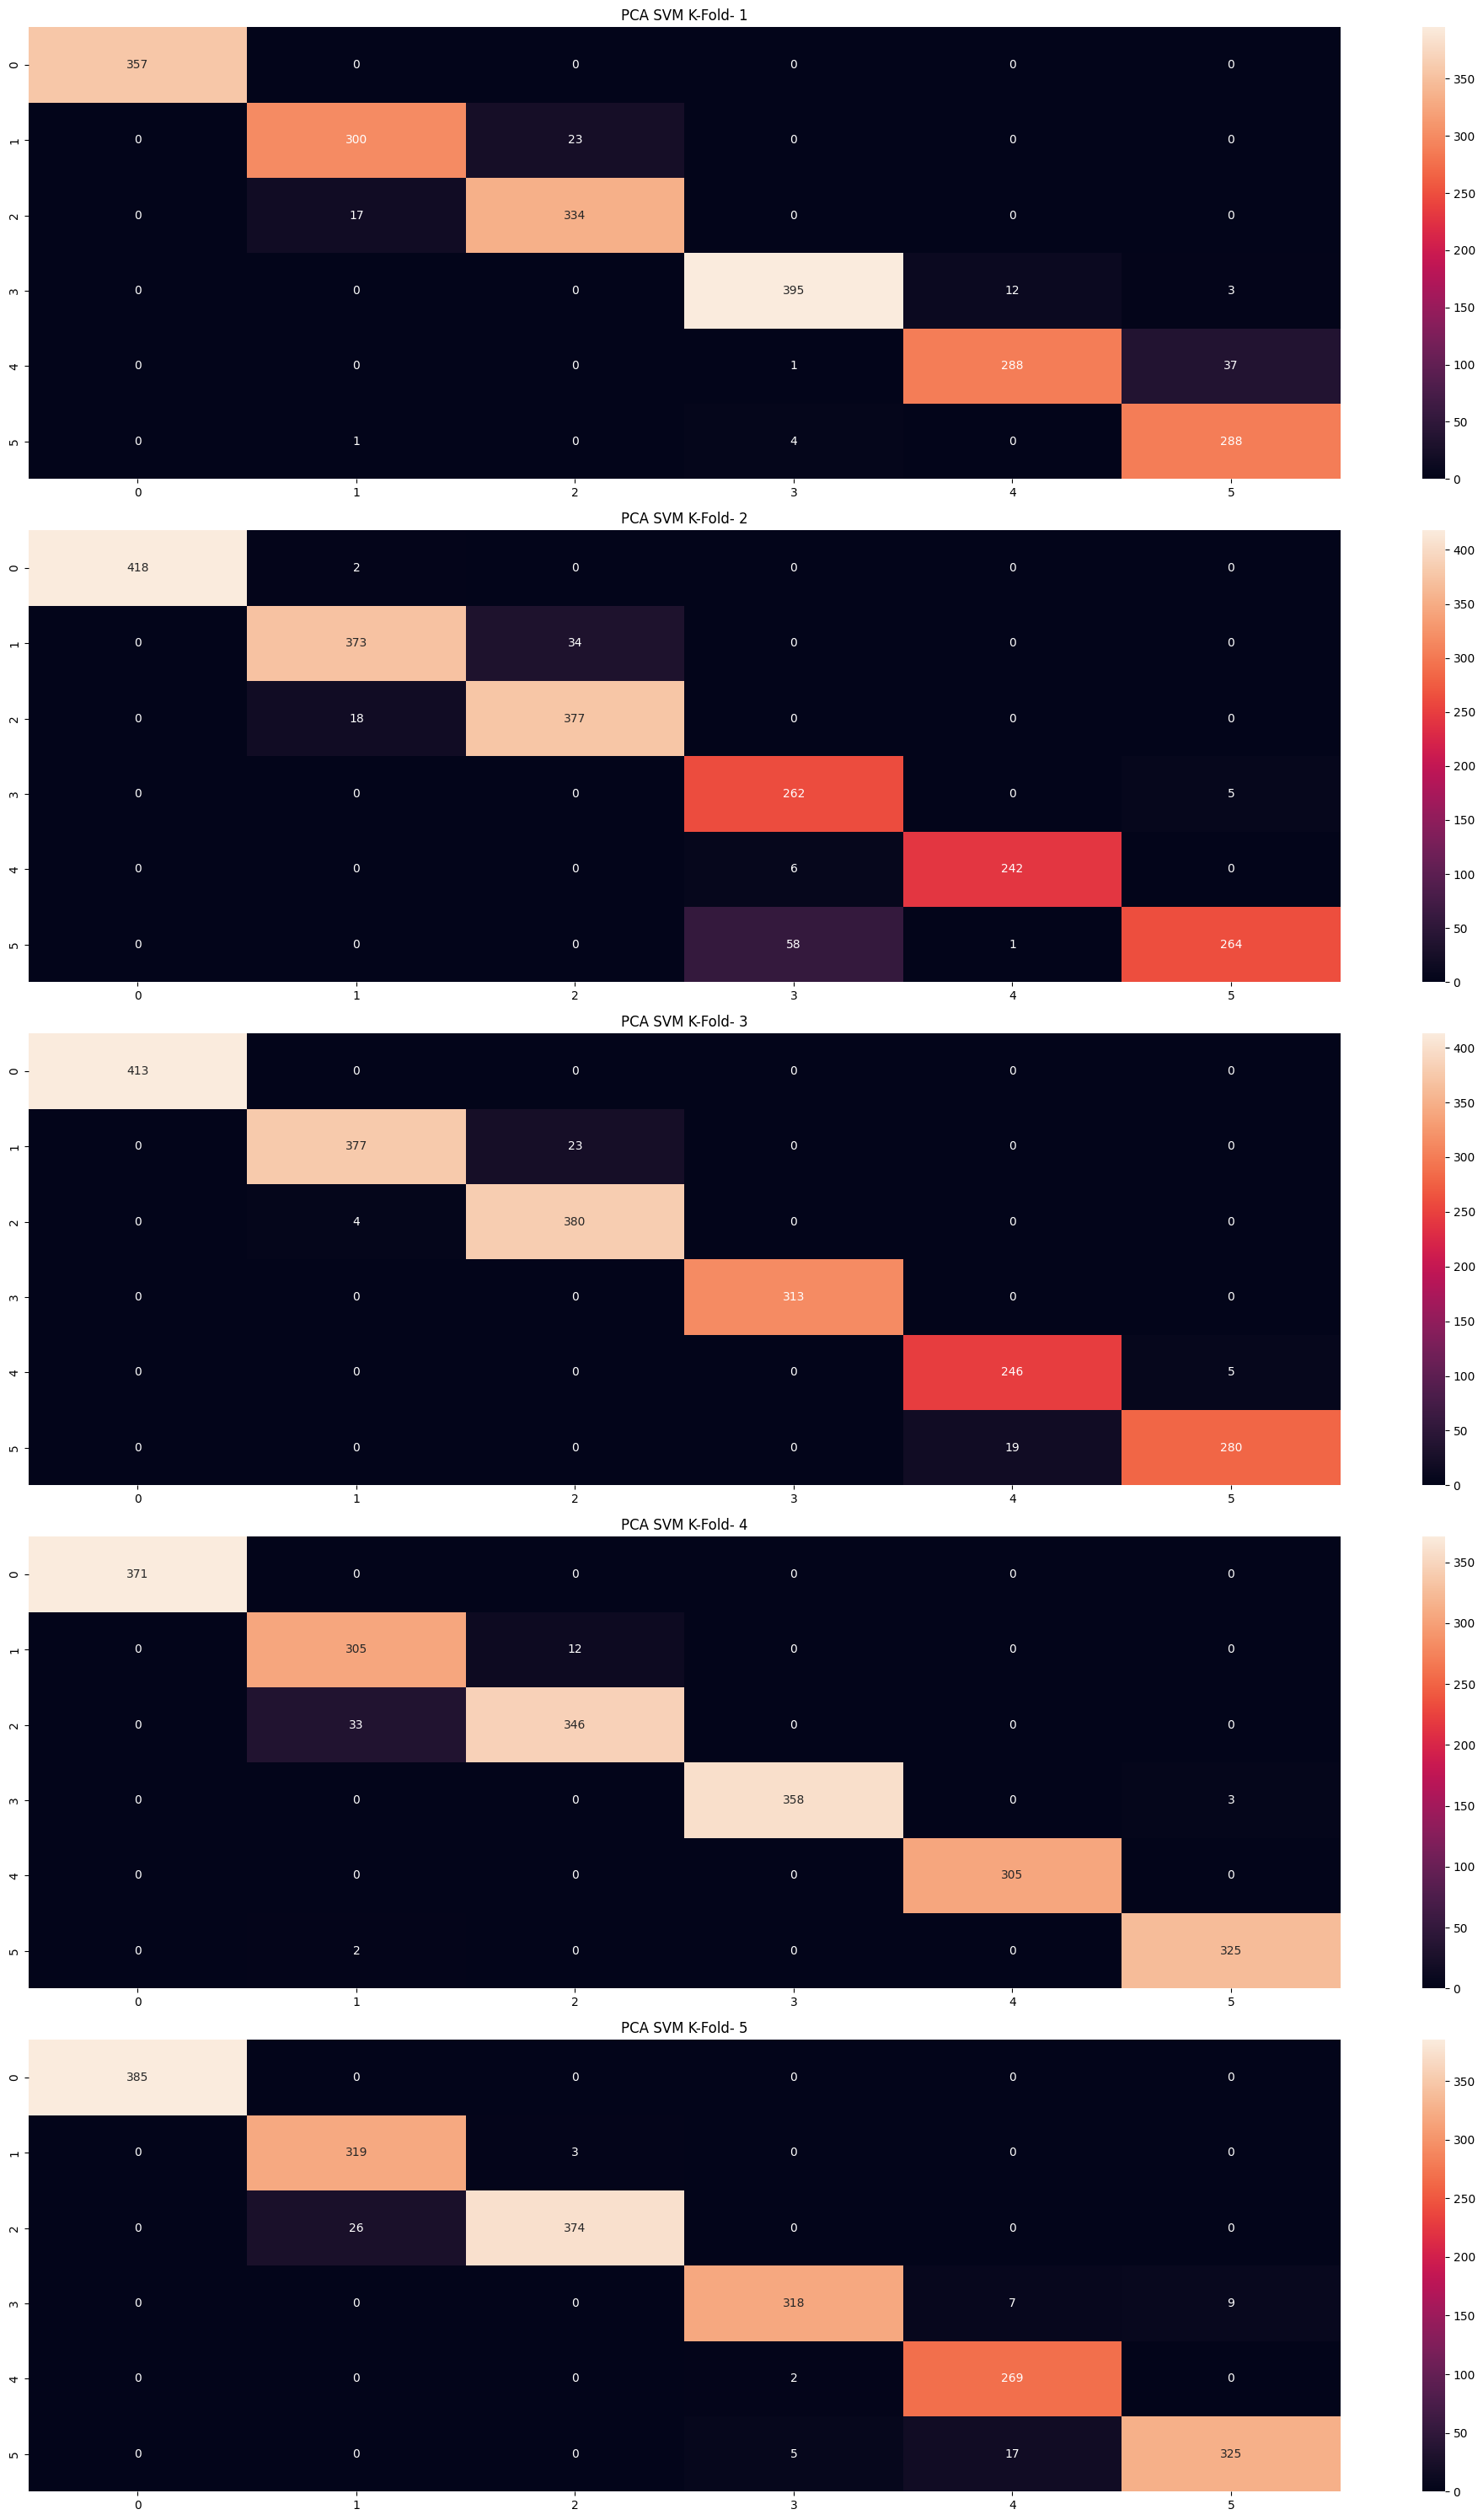

In [20]:
heatmap_drawing(svm_cfs,'PCA SVM K-Fold-')

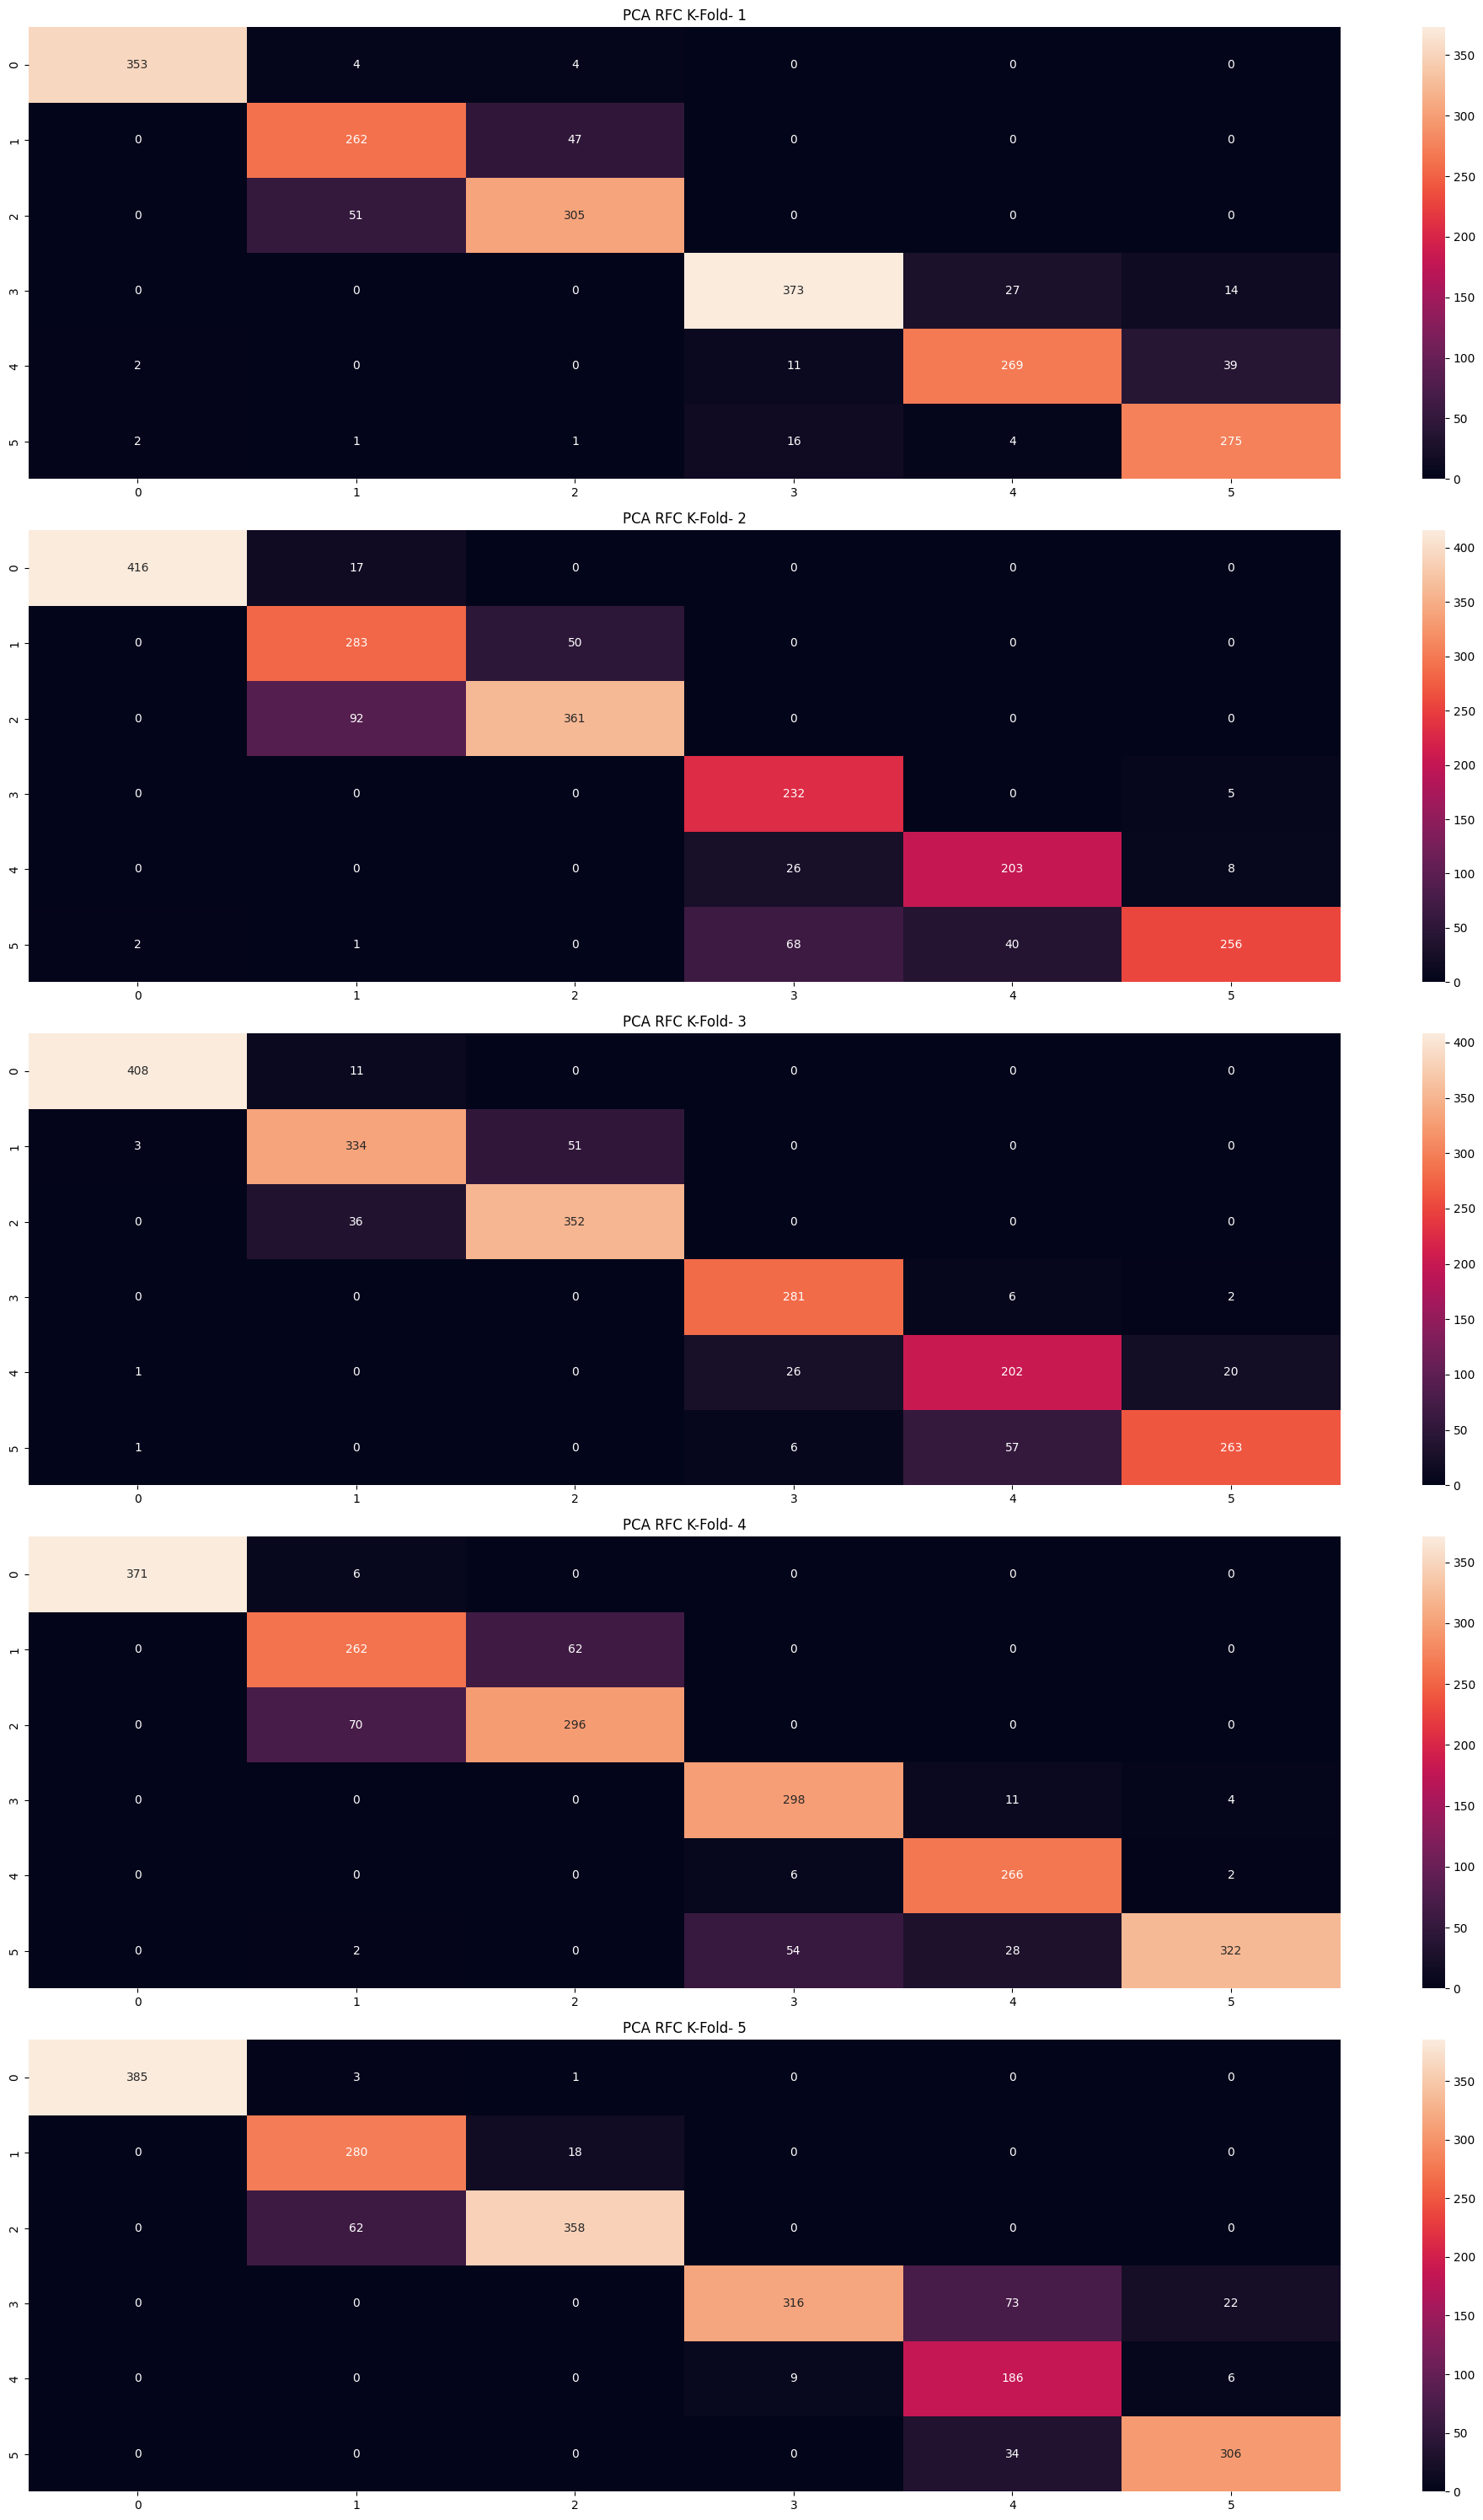

In [21]:
heatmap_drawing(rfc_cfs,'PCA RFC K-Fold-')

In [11]:
np.save("KNN_cfs",knn_cfs)

In [13]:
cfs_knn = np.load("KNN_cfs.npy")

In [14]:
cfs_knn

array([[[355,   0,   0,   0,   0,   0],
        [  0, 282,  73,   0,   0,   0],
        [  0,  34, 284,   0,   0,   0],
        [  1,   0,   0, 384,  27,  14],
        [  1,   0,   0,   2, 269,  48],
        [  0,   2,   0,  14,   4, 266]],

       [[418,   7,   0,   0,   0,   0],
        [  0, 287,  69,   0,   0,   0],
        [  0,  99, 342,   0,   0,   0],
        [  0,   0,   0, 274,   0,   9],
        [  0,   0,   0,  28, 231,   3],
        [  0,   0,   0,  24,  12, 257]],

       [[410,   2,   0,   0,   0,   0],
        [  3, 364,  74,   0,   0,   0],
        [  0,  15, 329,   0,   0,   0],
        [  0,   0,   0, 290,   9,   6],
        [  0,   0,   0,  22, 226,  15],
        [  0,   0,   0,   1,  30, 264]],

       [[371,   0,   0,   0,   0,   0],
        [  0, 285,  56,   0,   0,   0],
        [  0,  53, 302,   0,   0,   0],
        [  0,   0,   0, 349,  10,   7],
        [  0,   0,   0,   1, 288,   9],
        [  0,   2,   0,   8,   7, 312]],

       [[384,   0,   0,   0,   0